# Learning to Throw

[![Google Collab Book](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tum-pbs/PhiFlow/blob/develop/examples/optim/Learn_Throw.ipynb)

This example trains neural networks to solve inverse throwing problems.
Check out the corresponding [optimization](https://tum-pbs.github.io/PhiFlow/examples/optim/Optimize_Throw.html) example which finds the optimal trajectory using gradient descent.

In [1]:
%pip install --quiet phiflow
from phi.torch.flow import *
# from phi.flow import *  # If JAX is not installed. You can use phi.jax or phi.tf as well.

We define the 

In [2]:
def simulate_hit(pos, height, vel, angle, gravity=1.):
    vel_x, vel_y = math.cos(angle) * vel, math.sin(angle) * vel
    height = math.maximum(height, .01)
    hit_time = (vel_y + math.sqrt(vel_y**2 + 2 * gravity * height)) / gravity
    return pos + vel_x * hit_time, hit_time, height, vel_x, vel_y

def sample_trajectory(pos, height, vel, angle, gravity=1., steps=spatial(time=100)):
    _, hit_time, height, vel_x, vel_y = simulate_hit(pos, height, vel, angle, gravity)
    t = math.linspace(0, hit_time, steps)
    return vec(x=pos + vel_x * t, y=height + vel_y * t - gravity / 2 * t ** 2)

Next, we generate a training set and test by sampling random values.

In [35]:
def generate_data(shape):
  pos = math.random_normal(shape)
  height = math.random_uniform(shape) + .5
  vel = math.random_uniform(shape)
  angle = math.random_uniform(shape) * PI/2
  return math.stack(dict(pos=pos, height=height, vel=vel, angle=angle), channel('vector'))

x_train = generate_data(batch(example=1000))
x_test = generate_data(batch(example=1000))
y_train = simulate_hit(*x_train.vector)[0]
y_test = simulate_hit(*x_test.vector)[0]

We set up two networks with identical initialization, one for supervised training and one for diff.phys. training.

In [59]:
math.seed(0)
net_sup = dense_net(1, 4, [32, 64, 32])
math.seed(0)
net_dp = dense_net(1, 4, [32, 64, 32])
math.assert_close(get_parameters(net_sup)['linear1.weight'], get_parameters(net_dp)['linear1.weight'])

## Supervised Training
Now we can train the network. We feed the desired hit position into the network and predict a possible initial state.
For supervised training, we compare the network prediction to the ground truth from our training set.

In [60]:
opt_sup = adam(net_sup)

def supervised_loss(x, y, net=net_sup):
  prediction = math.native_call(net, y)
  return math.l2_loss(prediction - x), prediction

print(f"Initial supervised loss (test set): {supervised_loss(x_test, y_test)}")

sup_pred_trj = []
for i in range(200):
  update_weights(net_sup, opt_sup, supervised_loss, x_train, y_train)
  sup_pred_trj.append(math.native_call(net_sup, y_test))

print(f"Final supervised loss (test set): {supervised_loss(x_test, y_test)}")

Initial supervised loss (test set): ((exampleᵇ=1000) 1.620 ± 0.860 (3e-01...7e+00), (exampleᵇ=1000, vectorᶜ=4) 0.007 ± 0.026 (-8e-02...2e-01))
Final supervised loss (test set): ((exampleᵇ=1000) 0.282 ± 0.185 (1e-02...1e+00), (exampleᵇ=1000, vectorᶜ=4) 0.571 ± 0.588 (-3e+00...3e+00))


While there is progress, the final loss is not great.
Feel free to run more iterations but there is a deeper problem at work here.
Before we get into that, let's train a the network again but with a differentiable physics loss function.

## End-to-end Training with Differentiable Physics
For the differentiable physics loss, we simulate the trajectory given the initial conditions predicted by the network. Then we can measure how close to the desired location the network got.

In [61]:
opt_dp = adam(net_dp)

def physics_loss(y, net=net_dp):
  prediction = math.native_call(net, y)
  y_sim = simulate_hit(*prediction.vector)[0]
  return math.l2_loss(y_sim - y)

print(f"Initial supervised loss (test set): {supervised_loss(x_test, y_test, net=net_dp)}")

dp_pred_trj = []
for i in range(200):
  update_weights(net_dp, opt_dp, physics_loss, y_train)
  dp_pred_trj.append(math.native_call(net_dp, y_test))

print(f"Final supervised loss (test set): {supervised_loss(x_test, y_test, net=net_dp)}")

Initial supervised loss (test set): ((exampleᵇ=1000) 1.620 ± 0.860 (3e-01...7e+00), (exampleᵇ=1000, vectorᶜ=4) 0.007 ± 0.026 (-8e-02...2e-01))
Final supervised loss (test set): ((exampleᵇ=1000) 1.154 ± 0.684 (7e-02...4e+00), (exampleᵇ=1000, vectorᶜ=4) 0.196 ± 0.479 (-2e+00...2e+00))


This looks even worse! The differentiable physics network seems to stray even further from the ground truth.
Well, we're not trying to match the ground truth, though. Let's instead measure how close to the desired location the network threw the object.

In [62]:
print(f"Supervised network (test set): {physics_loss(y_test, net=net_sup)}")
print(f"Diff.Phys. network (test set): {physics_loss(y_test, net=net_dp)}")

Supervised network (test set): (exampleᵇ=1000) 0.004 ± 0.003 (2e-03...4e-02)
Diff.Phys. network (test set): (exampleᵇ=1000) 3.16e-05 ± 7.9e-05 (1e-11...2e-03)


This is much more promissing. The diff.phys. network seems to hit the desired location very accurately considering it was only trained for 200 iterations. With more training steps, this loss will go down even further, unlike the supervised network.

So what is going on here? Why does the supervised network perform so poorly?
The answer lies in the problem itself. The task is multi-modal, i.e. there are many initial states that will hit the same target.
The network only gets the target position and must decide on a single initial state. With supervised training, there is no way to know which ground truth solution occurs in the test set. The best the network can do is average nearby solutions from the training set. But since the problem is non-linear, this will give only a rough guess.

The diff.phys. network completely ignores the ground truth solutions which are not even passed to the `physics_loss` function. Instead, it learns to hit the desired spot, which is exactly what we want.

We can visualize the difference by looking at a couple of example trajectories.

In [66]:
opt_trjs = stack({
    "Ground truth": x_test,
    "Supervised": stack(sup_pred_trj, batch('iter')),
    "Diff.Phys.": stack(dp_pred_trj, batch('iter'))
}, channel('type'))
plot(sample_trajectory(*opt_trjs.example[:4].iter[::4].vector), animate='iter')

c:\phd\phiflow2\phiml\phiml\math\_shape.py:2048: RuntimeWarning: Stacking shapes with incompatible item names will result in item names being lost. For vector Got ('pos', 'height', 'vel', 'angle') and None
  warnings.warn(f"Stacking shapes with incompatible item names will result in item names being lost. For {name} Got {item_names[index]} and {items}", RuntimeWarning)


In the final state we can see that the differentiable physics network matches the hit point much more precisely than the supervised network, as expected from the loss values.

<Figure size 864x360 with 16 Axes>

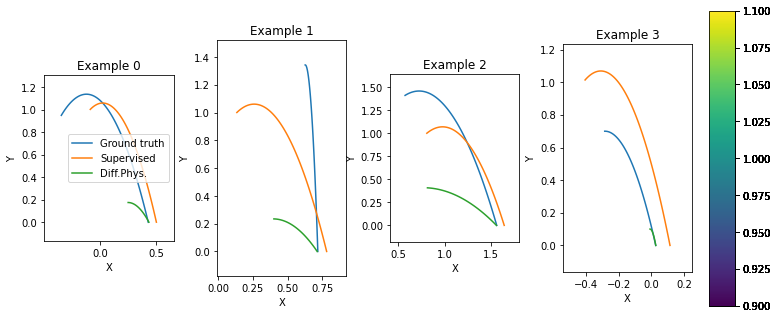

In [68]:
plot(sample_trajectory(*opt_trjs.example[:4].iter[-1].vector))